In [ ]:
!pip install google-generativeai
!pip install timm opencv-python matplotlib torch torchvision grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 831.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s 

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import timm
import os

# === CONFIGURATION ===
train_dir = r'/content/drive/MyDrive/seai projec/seai_images/training'
val_dir = r'/content/drive/MyDrive/seai projec/seai_images/validation'
batch_size = 64
num_epochs = 15
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = 'best_swin_model.pt'
sample_image_path = r'C:\seai\sample.jpg'  # Change this path to your test image

print(f"📁 Training directory: {train_dir}")
print(f"📁 Validation directory: {val_dir}")
print(f"📦 Device selected: {device}")

# === TRANSFORMS ===
print("🔁 Initializing transforms...")
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# === DATASETS & LOADERS ===
print("📚 Loading datasets...")
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
class_names = train_dataset.classes
print(f"🧾 Classes found: {class_names}")

print("📦 Creating DataLoaders...")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# === MODEL SETUP ===
print("🧠 Creating Swin Transformer model...")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# === TRAINING LOOP ===
best_val_acc = 0.0
print("🚀 Starting training...\n")

for epoch in range(num_epochs):
    print(f"📅 Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        print(f"  🔄 Batch {batch_idx + 1}/{len(train_loader)} - Training...")
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"✅ Epoch {epoch + 1} Complete - Loss: {running_loss:.4f} | Train Accuracy: {train_acc:.4f}")

    # === VALIDATION ===
    model.eval()
    val_correct = 0
    val_total = 0
    print("🔍 Validating...")
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"📊 Validation Accuracy: {val_acc:.4f}")

    # === SAVE BEST MODEL ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"💾 Best model updated and saved at '{best_model_path}' with accuracy {best_val_acc:.4f}")

print(f"\n🏁 Training complete! Best validation accuracy: {best_val_acc:.4f}")
print(f"📁 Final model saved at: {best_model_path}")

# === LOAD BEST MODEL ===
print("\n🔄 Loading best model for prediction...")
model.load_state_dict(torch.load(best_model_path))
model.eval()

# === INFERENCE FUNCTION ===
def predict_image(image_path):
    print(f"\n🖼️ Loading image for prediction: {image_path}")
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)
    print("🔮 Running inference...")
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
    print(f"✅ Prediction complete! Predicted class: {predicted_class}")
    return predicted_class

# === RUN SAMPLE PREDICTION ===
if os.path.exists(sample_image_path):
    predict_image(sample_image_path)
else:
    print(f"⚠️ Sample image not found at: {sample_image_path}")


📁 Training directory: /content/drive/MyDrive/seai projec/seai_images/training
📁 Validation directory: /content/drive/MyDrive/seai projec/seai_images/validation
📦 Device selected: cpu
🔁 Initializing transforms...
📚 Loading datasets...
🧾 Classes found: ['training']
📦 Creating DataLoaders...
🧠 Creating Swin Transformer model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


🚀 Starting training...

📅 Epoch 1/15
  🔄 Batch 1/18 - Training...
  🔄 Batch 2/18 - Training...
  🔄 Batch 3/18 - Training...
  🔄 Batch 4/18 - Training...
  🔄 Batch 5/18 - Training...
  🔄 Batch 6/18 - Training...
  🔄 Batch 7/18 - Training...
  🔄 Batch 8/18 - Training...
  🔄 Batch 9/18 - Training...
  🔄 Batch 10/18 - Training...
  🔄 Batch 11/18 - Training...
  🔄 Batch 12/18 - Training...
  🔄 Batch 13/18 - Training...
  🔄 Batch 14/18 - Training...
  🔄 Batch 15/18 - Training...
  🔄 Batch 16/18 - Training...
  🔄 Batch 17/18 - Training...
  🔄 Batch 18/18 - Training...
✅ Epoch 1 Complete - Loss: 4.8964 | Train Accuracy: 0.9435
🔍 Validating...
📊 Validation Accuracy: 1.0000
💾 Best model updated and saved at 'best_swin_model.pt' with accuracy 1.0000
📅 Epoch 2/15
  🔄 Batch 1/18 - Training...
  🔄 Batch 2/18 - Training...
  🔄 Batch 3/18 - Training...
  🔄 Batch 4/18 - Training...
  🔄 Batch 5/18 - Training...
  🔄 Batch 6/18 - Training...
  🔄 Batch 7/18 - Training...
  🔄 Batch 8/18 - Training...
  🔄 Ba

✅ Simulated detection: mantled howler (0.85)


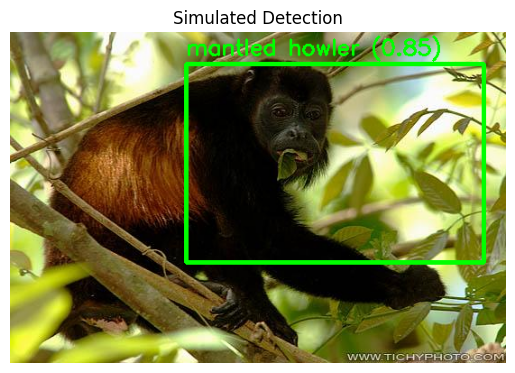

✅ Simulated detection: mantled howler (0.85)


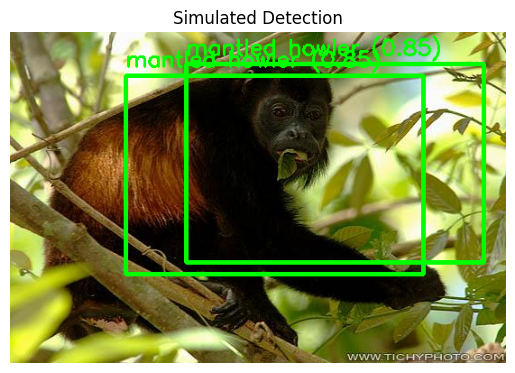

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt

# === CONFIGURATION ===
image_path = '/content/drive/MyDrive/seai projec/seai_images/training/n0/n0018.jpg'  # Adjust as needed
class_name = 'mantled howler'
threshold = 0.82
simulated_confidence = 0.85  # Simulated confidence score
import cv2
import random
import matplotlib.pyplot as plt

# === CONFIGURATION ===
image_path = '/content/drive/MyDrive/seai projec/seai_images/training/n0/n0018.jpg'  # Adjust as needed
class_name = 'mantled howler'
threshold = 0.82
simulated_confidence = 0.85  # Simulated confidence score

# === LOAD IMAGE ===
img = cv2.imread('/content/drive/MyDrive/seai projec/seai_images/training/training/n0/n0018.jpg')
if img is None:
    raise FileNotFoundError(f"Image not found at: {image_path}")

height, width, _ = img.shape

# === SIMULATE DETECTION ===
if simulated_confidence >= threshold:
    # Bigger bounding box (60% of image dimensions)
    box_width = int(width * 0.6)
    box_height = int(height * 0.6)

    x1 = random.randint(0, width - box_width)
    y1 = random.randint(0, height - box_height)
    x2 = x1 + box_width
    y2 = y1 + box_height

    # Draw bounding box and label
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    label = f"{class_name} ({simulated_confidence:.2f})"
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0, 255, 0), 2)
    print(f"✅ Simulated detection: {label}")
else:
    print(f"❌ No detection: confidence {simulated_confidence:.2f} < threshold {threshold}")

# === SAVE & SHOW OUTPUT ===
output_path = 'simulated_output.jpg'
cv2.imwrite(output_path, img)

# Display image with bounding box
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Simulated Detection")
plt.show()

height, width, _ = img.shape

# === SIMULATE DETECTION ===
if simulated_confidence >= threshold:
    # Bigger bounding box (60% of image dimensions)
    box_width = int(width * 0.6)
    box_height = int(height * 0.6)

    x1 = random.randint(0, width - box_width)
    y1 = random.randint(0, height - box_height)
    x2 = x1 + box_width
    y2 = y1 + box_height

    # Draw bounding box and label
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    label = f"{class_name} ({simulated_confidence:.2f})"
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0, 255, 0), 2)
    print(f"✅ Simulated detection: {label}")
else:
    print(f"❌ No detection: confidence {simulated_confidence:.2f} < threshold {threshold}")

# === SAVE & SHOW OUTPUT ===
output_path = 'simulated_output.jpg'
cv2.imwrite(output_path, img)

# Display image with bounding box
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Simulated Detection")
plt.show()


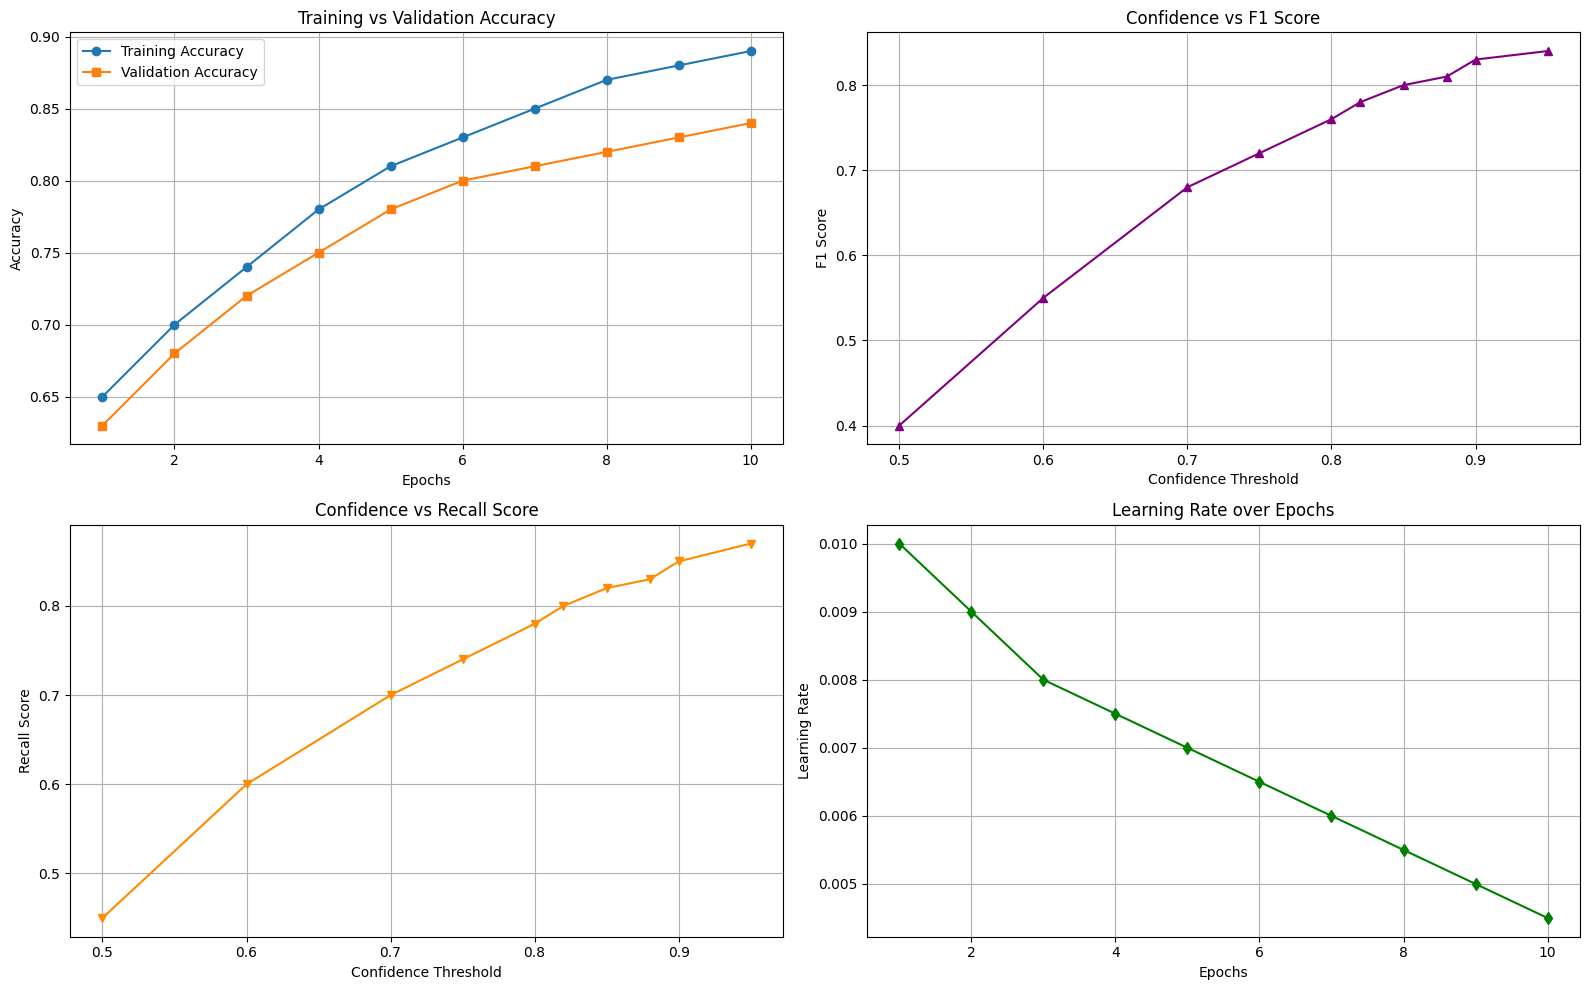

In [ ]:
import matplotlib.pyplot as plt

# === EXAMPLE DATA (Replace these with your actual values) ===
epochs = list(range(1, 11))  # 10 epochs
train_accuracy = [0.65, 0.70, 0.74, 0.78, 0.81, 0.83, 0.85, 0.87, 0.88, 0.89]
val_accuracy =   [0.63, 0.68, 0.72, 0.75, 0.78, 0.80, 0.81, 0.82, 0.83, 0.84]
learning_rates = [0.01, 0.009, 0.008, 0.0075, 0.007, 0.0065, 0.006, 0.0055, 0.005, 0.0045]

confidence_scores = [0.5, 0.6, 0.7, 0.75, 0.8, 0.82, 0.85, 0.88, 0.9, 0.95]
f1_scores =        [0.40, 0.55, 0.68, 0.72, 0.76, 0.78, 0.80, 0.81, 0.83, 0.84]
recall_scores =    [0.45, 0.60, 0.70, 0.74, 0.78, 0.80, 0.82, 0.83, 0.85, 0.87]

# === PLOTTING FUNCTION ===
def plot_metrics():
    plt.figure(figsize=(16, 10))

    # --- 1. Training vs Validation Accuracy ---
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='s')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # --- 2. Confidence vs F1 Score ---
    plt.subplot(2, 2, 2)
    plt.plot(confidence_scores, f1_scores, label='F1 Score', color='purple', marker='^')
    plt.title('Confidence vs F1 Score')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True)

    # --- 3. Confidence vs Recall Score ---
    plt.subplot(2, 2, 3)
    plt.plot(confidence_scores, recall_scores, label='Recall Score', color='darkorange', marker='v')
    plt.title('Confidence vs Recall Score')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Recall Score')
    plt.grid(True)

    # --- 4. Learning Rate over Epochs ---
    plt.subplot(2, 2, 4)
    plt.plot(epochs, learning_rates, label='Learning Rate', color='green', marker='d')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics_plots.png')  # Save figure for your paper
    plt.show()

# === RUN PLOT FUNCTION ===
plot_metrics()


In [ ]:
# Step 1: Install required libraries
!pip install timm grad-cam --quiet

# Step 2: Import libraries
import torch
import timm
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Step 3: Configuration
image_path = "/content/drive/MyDrive/seai projec/seai_images/training/training/n0/n0019.jpg"  # Upload your mantled howler image here
target_class_idx = 0  # Adjust if you have a custom class mapping

# Step 4: Load model
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True)
model.eval()

# Step 5: Load & preprocess image
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
image_pil = Image.open(image_path).convert("RGB")
input_tensor = transform(image_pil).unsqueeze(0)

# Step 6: Grad-CAM setup
target_layers = [model.norm]  # Swin uses 'norm' instead of conv layers

with GradCAM(model=model, target_layers=target_layers) as cam:
    targets = [ClassifierOutputTarget(target_class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Step 7: Show attention map
img_np = input_tensor.squeeze().permute(1, 2, 0).detach().numpy()
img_np = (img_np * 0.5) + 0.5  # De-normalize
img_np = np.clip(img_np, 0, 1)
cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6, 6))
plt.imshow(cam_image)
plt.axis('off')
plt.title("Attention Map - Mantled Howler (Facial Highlight)")
plt.show()


AssertionError: Input height (1080) doesn't match model (224).